In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
from scipy import sparse
import anndata
import scipy.io as sio

## Data integration

In [13]:
wu= sc.read_h5ad('./processed/wu_filtered.h5ad')

In [14]:
savas= sc.read_h5ad('./processed/savas_filtered.h5ad')

In [15]:
xu = sc.read_h5ad('./processed/xu_filtered.h5ad')

In [5]:
# calculate HGVs
sc.pp.highly_variable_genes(wu, n_top_genes=10000, flavor='cell_ranger')
wu = wu[:, wu.var.highly_variable]    
sc.pp.highly_variable_genes(savas, n_top_genes=10000, flavor='cell_ranger')
savas = savas[:, savas.var.highly_variable]    
sc.pp.highly_variable_genes(xu, n_top_genes=10000, flavor='cell_ranger')
xu = xu[:, xu.var.highly_variable]    

In [16]:
# connect datasets, use common HGVs
var_names = wu.var_names.intersection(xu.var_names)
xu = xu[:, var_names]
var_names = savas.var_names.intersection(xu.var_names)
xu = xu[:, var_names]
savas = savas[:, var_names]
wu = wu[:, var_names]

In [23]:
adata_concat = wu.concatenate([xu, savas] , batch_categories=['wu', 'xu', 'savas'] )
results_file = './processed/connected_common_genes.h5ad'
adata_concat.write(results_file)

/home/olam/miniconda3/envs/single/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [13]:
# scale and regress out mt effects
sc.pp.regress_out(xu, ['total_counts', 'pct_counts_mt'])
sc.pp.regress_out(wu, ['total_counts', 'pct_counts_mt'])
sc.pp.regress_out(savas, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(xu, max_value=10)
sc.pp.scale(wu, max_value=10)
sc.pp.scale(savas, max_value=10)

In [18]:
sc.tl.pca(adata_concat)

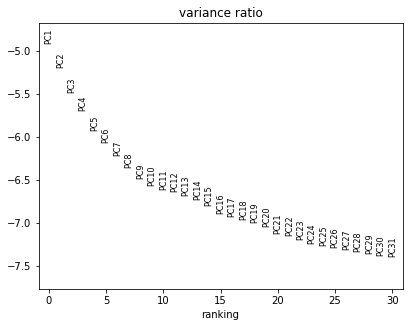

In [19]:
sc.pl.pca_variance_ratio(adata_concat, log=True)

In [ ]:
# save checkpoint
results_file = './processed/conected_pca_alls_scaled.h5ad'
adata_concat.write(results_file)

In [3]:
# run Harmony PCA correction
import scanpy.external as sce
sce.pp.harmony_integrate(adata_concat, ['batch', 'Tissue','Patient'])

2022-06-27 01:00:57,099 - harmonypy - INFO - Iteration 1 of 10
2022-06-27 01:03:03,053 - harmonypy - INFO - Iteration 2 of 10
2022-06-27 01:05:09,074 - harmonypy - INFO - Converged after 2 iterations


In [6]:
# save checkpoint
results_file = './processed/integration_2_alls_scaled_harmony.h5ad'
adata_concat.write(results_file)

## Cluster analysis

In [5]:
sc.pp.neighbors(adata_concat, n_neighbors=30, n_pcs=20, use_rep = 'X_pca_harmony')

/home/olam/miniconda3/envs/single/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
sc.tl.leiden(adata_concat, resolution=0.3)

In [9]:
sc.tl.paga(adata_concat)
sc.pl.paga(adata_concat, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata_concat, init_pos='paga')

In [10]:
results_file = './processed/integration_umap_2_alls_scaled_harmony.h5ad'
adata_concat.write(results_file)

In [ ]:
results_file = './processed/integration_ctypes_harmony.h5ad'
adata_all.write(results_file)

In [2]:
adata_concat = sc.read_h5ad('./processed/integration_umap_2_alls_scaled_harmony.h5ad')

In [3]:
adata_all = sc.read_h5ad('./processed/connected_common_genes.h5ad')

In [15]:
results_file = './processed/integration_harmony.h5ad'
adata_all.write(results_file)

In [4]:
adata_all.uns = adata_concat.uns
adata_all.obsm = adata_concat.obsm
adata_all.obsp = adata_concat.obsp
adata_all.obs['leiden'] = adata_concat.obs['leiden']

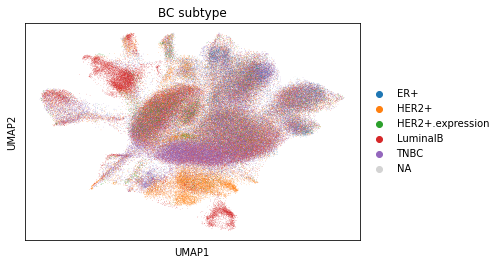

In [35]:
sc.pl.umap(adata_all, color='BC subtype')

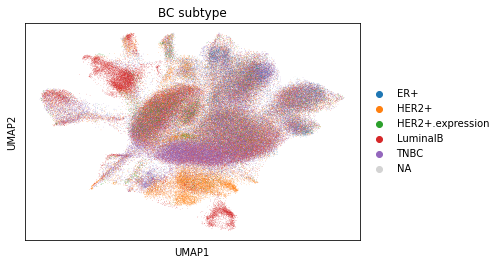

In [5]:
sc.pl.umap(adata_concat, color='BC subtype')

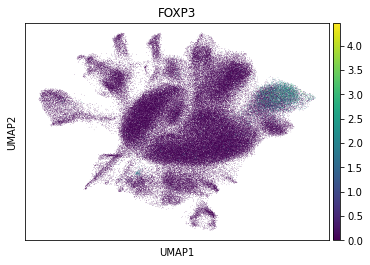

In [40]:
sc.pl.umap(adata_all, color=['FOXP3'])

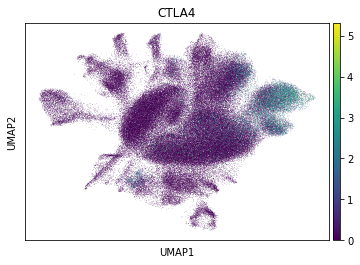

In [41]:
sc.pl.umap(adata_all, color=['CTLA4'])

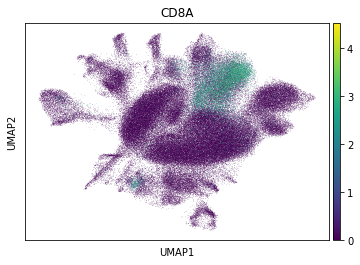

In [42]:
sc.pl.umap(adata_all, color=['CD8A'])

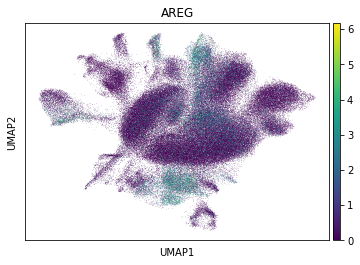

In [43]:
sc.pl.umap(adata_all, color=['AREG'])

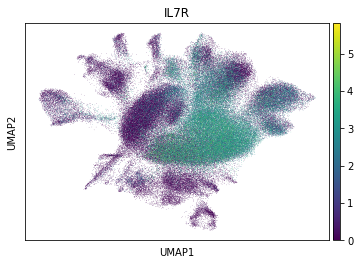

In [36]:
sc.pl.umap(adata_all, color=['IL7R'])

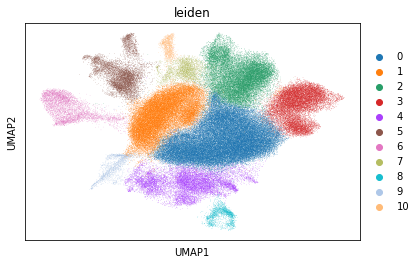

In [46]:
sc.pl.umap(adata_all, color=['leiden'])

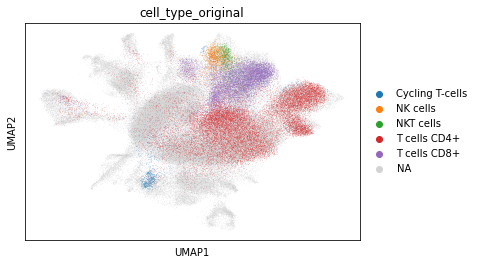

In [7]:
sc.pl.umap(adata_all, color=['cell_type_original'])

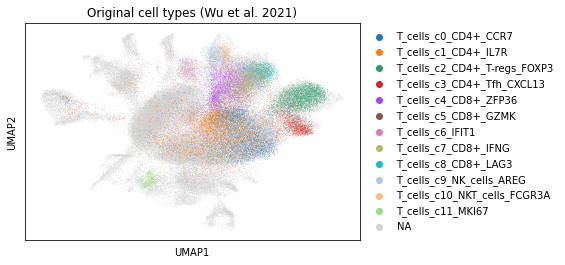

In [11]:
sc.pl.umap(adata_all, color=['cell_type_original_subset'], title="Original cell types (Wu et al. 2021)")

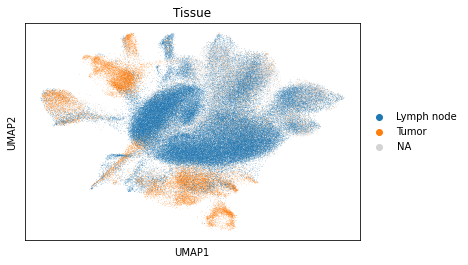

In [12]:
sc.pl.umap(adata_all, color=['Tissue'])

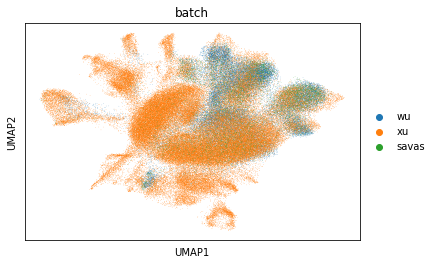

In [14]:
sc.pl.umap(adata_all, color=['batch'])

In [16]:
import cello

In [17]:
import os
cello_resource_loc = os.getcwd()

In [ ]:
model_prefix = "BC subtypes" # <-- The trained model will be stored in a file called GSM3516666_LX682_NORMAL.model.dill 

cello.scanpy_cello(
    adata_all, 
    'leiden',
    cello_resource_loc, 
    out_prefix=model_prefix
)

# TO DO

## No batch correction

In [ ]:
adata_concat = sc.read_h5ad('./processed/conected_pca_alls_scaled.h5ad')

In [ ]:
sc.tl.leiden(adata_concat, resolution=0.3)
sc.tl.paga(adata_concat)
sc.pl.paga(adata_concat, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata_concat, init_pos='paga')

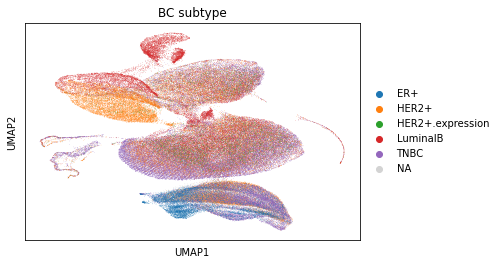

In [7]:
sc.pl.umap(adata_concat, color='BC subtype')

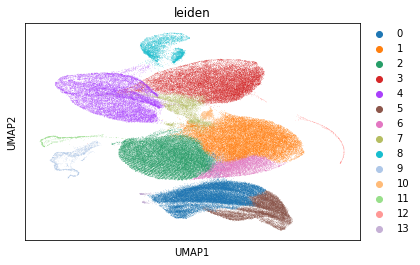

In [6]:
sc.pl.umap(adata_concat, color='leiden')

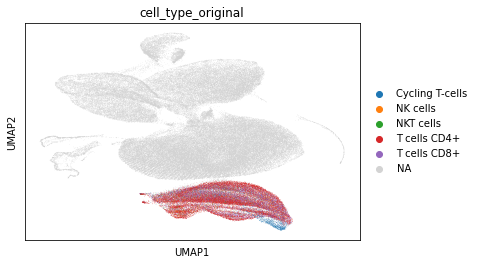

In [8]:
sc.pl.umap(adata_concat, color='cell_type_original')

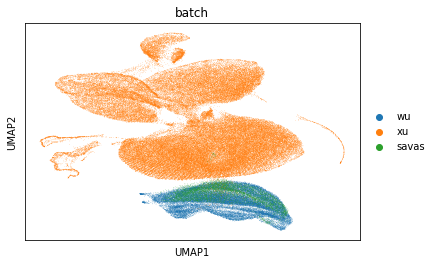

In [9]:
sc.pl.umap(adata_concat, color='batch')

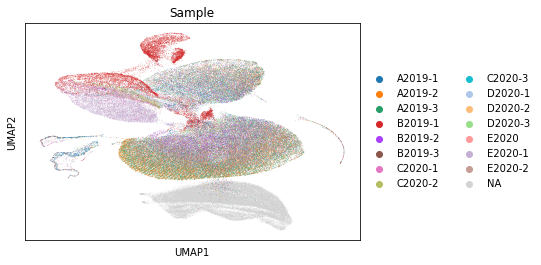

In [15]:
sc.pl.umap(adata_concat, color='Sample')

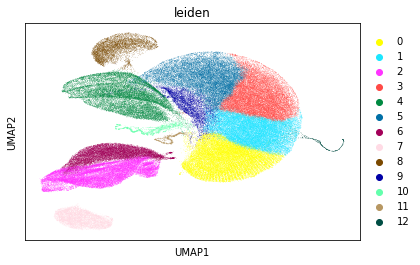

In [8]:
sc.pl.umap(adata_concat, color='leiden')

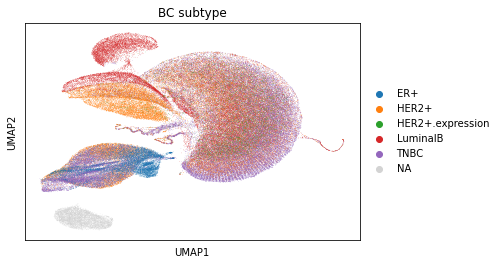

In [11]:
sc.pl.umap(adata_concat, color='BC subtype')

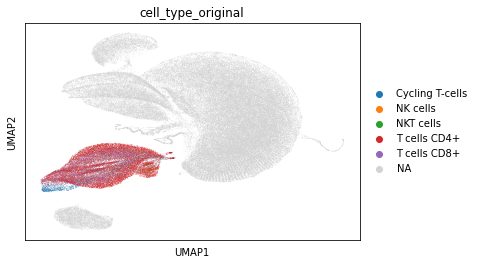

In [12]:
sc.pl.umap(adata_concat, color='cell_type_original')

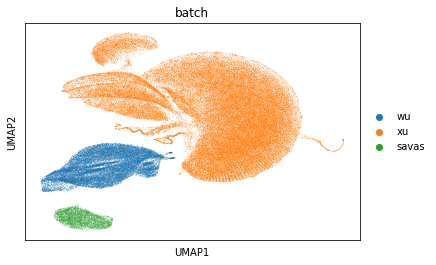

In [6]:
sc.pl.umap(adata_concat, color='batch')